In [1]:
import pandas as pd
import os
import time

In [2]:
def get_filepaths(all_data_directory):
    directory = all_data_directory
    paths = []
    for filename in os.listdir(directory):
        path = os.path.join(directory, filename)
        if os.path.isdir(path+"/surveys"):
            paths.append(path+"/surveys")
    return paths

In [3]:
# directory = '/Users/jerenolsen/Desktop/Exploring PGP Harvard/Complete Genomics/all-data-by-profile'
# [print(path) for path in get_filepaths(directory)] 

In [4]:
def read_table(path, profile_id):
    df = pd.read_csv(path, delimiter = '\t')
    df['profile_id'] = profile_id
    
    return df

def get_txt_profiles(txt_path):
    df = pd.read_csv(txt_path, delimiter = '\t', header = None)
    profiles = df[0].values.tolist()
    return profiles

def remove_intersecting_profiles(paths, provider_id):
    _23andMe_profiles = '/Users/jerenolsen/Desktop/Exploring PGP Harvard/23andMe/PGP_HVD_23andMe_complete_profiles.txt'
    CG_profiles = '/Users/jerenolsen/Desktop/Exploring PGP Harvard/Complete Genomics/PGP_HVD_CG_complete_profiles.txt'
    VG_profiles = '/Users/jerenolsen/Desktop/Exploring PGP Harvard/Veritas Genetics/PGP_HVD_VG_complete_profiles.txt'
    
    _23andMe = get_txt_profiles(_23andMe_profiles)
    CG = get_txt_profiles(CG_profiles)
    VG = get_txt_profiles(VG_profiles)
    
    if provider_id == '23andMe':
        pass #Keep all profiles
    elif provider_id == 'CG':
        paths = [path for path in paths if path[-13:-5] not in _23andMe]
    elif provider_id == 'VG':
        paths = [path for path in paths if path[-13:-5] not in _23andMe]
        paths = [path for path in paths if path[-13:-5] not in CG]
    else:
        return None
    
    return paths 

In [5]:
def get_stuff(directory, provider_id):
    
    paths = get_filepaths(directory)
    paths = remove_intersecting_profiles(paths, provider_id)
    
    names_df = pd.DataFrame()
    cancers_df = pd.DataFrame()
    for path in paths:
        profile_id = path[-16:-8]
        try:
            for survey in os.listdir(path):
                survey = os.path.join(path, survey)
                df = read_table(survey, profile_id)
                name = survey.rsplit('/', 1)[-1]
                df1 = pd.DataFrame.from_dict({'name': [name.upper()]})

                if name.upper() == 'PGP TRAIT & DISEASE SURVEY 2012: CANCERS.TSV':
                    df.drop(labels = 'Unnamed: 0',axis = 1, inplace = True)
                    cancers_df = pd.concat([cancers_df, df.iloc[-1]])
                    
                names_df = pd.concat([names_df, df1])

        except Exception as e:
            pass
            #print(f"Exception: {e}\n")
    return names_df, cancers_df

def get_survey_type(directory, provider_id, survey_substring):
    "Survey string can be any substring contained in survey name that identifies it uniquely (ie. 'Congenital')"
    
    paths = get_filepaths(directory)
    paths = remove_intersecting_profiles(paths, provider_id)
    
    survey_df = pd.DataFrame()
    for path in paths:
        profile_id = path[-16:-8]
        try:
            for survey in os.listdir(path):
                survey = os.path.join(path, survey)
                df = read_table(survey, profile_id)
                name = survey.rsplit('/', 1)[-1]
            
                if survey_substring.upper() in name.upper():
                    df.drop(labels = 'Unnamed: 0',axis = 1, inplace = True)
                    survey_df = pd.concat([survey_df, df])

        except Exception as e:
            pass
            #print(f"Exception: {e}\n")
            
    #DEBUGGING
    #survey_df = survey_df.reset_index()
    #survey_df = survey_df[survey_df["index"].contains('profile_id') == False]
    #survey_df.drop(labels = 'index',axis = 1, inplace =True)
        
    return survey_df

    
def expand_responses(df):
    df.rename(columns = {0:'response'}, inplace = True)
    df = df.assign(expanded = df.response.str.split(",")).explode('expanded')
    df.drop(labels = 'response', axis = 1, inplace = True)
    df.rename(columns = {'expanded':'response'}, inplace = True)
    return df
    
def get_survey_value_counts(survey_df, display = False, explode = False):
    survey_df = survey_df[survey_df[0].str.contains('Have you ever') == False]
    survey_df = survey_df[survey_df[0].str.contains('Timestamp') == False]
    survey_df = survey_df[survey_df[0].str.contains(':') == False]
    survey_df = survey_df[survey_df[0].str.contains('listed here') == False]
    survey_df = survey_df[survey_df[0].str.contains('None') == False]
    survey_df = survey_df[survey_df[0].str.contains('none') == False]
    
    if explode:
        survey_df = expand_responses(survey_df)
    
    if display:
        pd.set_option("display.max_rows", None)
        print(survey_df['response'].value_counts())
        
    return survey_df['response'].value_counts()
    
def retrieve_survey_controller(directory, provider_id, survey_substring):
    surveys = get_survey_type(directory, provider_id, survey_substring)
    #counts = get_survey_value_counts(surveys, display = False, explode = True)
    
    #DEBUGGING
    return surveys#, counts



In [9]:
#PGP BASIC PHENOTYPES SURVEY 2015.TSV
directory_CG = '/Users/jerenolsen/Desktop/Exploring PGP Harvard/Complete Genomics/all-data-by-profile'
surveys = retrieve_survey_controller(directory_CG, 'CG', 'phenotypes')
surveys.head(20)
#surveys = surveys[surveys['0'].str.contains('Blood')]
#surveys['1'].value_counts()

,0,1,profile_id
0,PGP Basic Phenotypes Survey 2015,Responses submitted 8/29/2015 21:25:11. Show ...,hu26B551
1,Timestamp,8/29/2015 21:25:11,hu26B551
2,1.1 — Blood Type,Don't know,hu26B551
3,1.2 — Height,"5'7""",hu26B551
4,1.3 — Weight,145,hu26B551
5,2.1 — Left Eye (Photograph Number) (full-size ...,7,hu26B551
6,2.2 — Right Eye (Photograph Number) (full-size...,7,hu26B551
7,2.3 — Left Eye Color - Text Description,"Blue, with only a touch of greenish brown near...",hu26B551
8,2.4 — Right Eye Color - Text Description,"Blue, with only a touch of greenish brown near...",hu26B551
9,2.5 —Comments,I believe my eye color has always been the sam...,hu26B551


In [17]:
directory_CG = '/Users/jerenolsen/Desktop/Exploring PGP Harvard/Complete Genomics/all-data-by-profile'
surveys = retrieve_survey_controller(directory_CG, 'CG', 'participant')
surveys.head(20)

,0,1,profile_id
0,PGP Participant Survey,Responses submitted 10/11/2012 23:42:49. Show...,hu26B551
1,Timestamp,10/11/2012 23:42:49,hu26B551
2,Year of birth,50-59 years,hu26B551
3,Which statement best describes you?,I am comfortable making my genome sequence dat...,hu26B551
4,Severe disease or rare genetic trait,No,hu26B551
5,Sex/Gender,Female,hu26B551
6,Race/ethnicity,White,hu26B551
7,Maternal grandmother: Country of origin,United States,hu26B551
8,Paternal grandmother: Country of origin,United States,hu26B551
9,Paternal grandfather: Country of origin,United States,hu26B551


## Survey Counts Complete Genomics

In [6]:
# directory = '/Users/jerenolsen/Desktop/Exploring PGP Harvard/Complete Genomics/all-data-by-profile'
# names_df, cancers_df = get_stuff(directory, provider_id = 'CG')
# names_df['name'].value_counts()

## Cancer Positive Surveys CG

In [7]:
#get_cancer_occurences(cancers_df)

## Congenital Traits Complete Genomics

In [8]:
# congenitals = get_survey_type(directory = '/Users/jerenolsen/Desktop/Exploring PGP Harvard/Complete Genomics/all-data-by-profile',
#                               provider_id = 'CG', survey_substring = 'Congenital')
# congenitals = congenitals[congenitals[0].str.contains('Timestamp') == False]
# congenitals = congenitals[congenitals[0].str.contains(':') == False]
# congenitals = congenitals[congenitals[0].str.contains('Have') == False]
# congenitals = congenitals[congenitals[0].str.contains('Other') == False]

In [9]:
#congenitals.value_counts()

## Complete Genomics Endocrine / Metabolic Counts

In [10]:
end_metab = end_metab = get_survey_type(directory = '/Users/jerenolsen/Desktop/Exploring PGP Harvard/Complete Genomics/all-data-by-profile', 
                              provider_id = 'CG', survey_substring = 'endocrine, metabolic')
get_survey_value_counts(end_metab, explode = True)

High cholesterol (hypercholesterolemia)                                                                         45
 High triglycerides (hypertriglyceridemia)                                                                      23
Lactose intolerance                                                                                             18
Hypothyroidism                                                                                                  16
 High cholesterol (hypercholesterolemia)                                                                        16
 type 2                                                                                                          8
Diabetes mellitus                                                                                                8
Thyroid nodule(s)                                                                                                8
 Hashimoto's thyroiditis                                                        

# 23andMe 

## Survey Counts 23andMe


In [11]:
directory = '/Users/jerenolsen/Desktop/Exploring PGP Harvard/23andMe/all-data-by-profile'
names_df, cancers_df = get_stuff(directory, provider_id = '23andMe')
names_df['name'].value_counts()

PGP PARTICIPANT SURVEY.TSV                                                              681
PGP TRAIT & DISEASE SURVEY 2012: CANCERS.TSV                                            543
PGP TRAIT & DISEASE SURVEY 2012: ENDOCRINE, METABOLIC, NUTRITIONAL, AND IMMUNITY.TSV    534
PGP TRAIT & DISEASE SURVEY 2012: BLOOD.TSV                                              527
PGP TRAIT & DISEASE SURVEY 2012: CONGENITAL TRAITS AND ANOMALIES.TSV                    524
PGP TRAIT & DISEASE SURVEY 2012: VISION AND HEARING.TSV                                 524
PGP TRAIT & DISEASE SURVEY 2012: SKIN AND SUBCUTANEOUS TISSUE.TSV                       519
PGP TRAIT & DISEASE SURVEY 2012: NERVOUS SYSTEM.TSV                                     515
PGP TRAIT & DISEASE SURVEY 2012: DIGESTIVE SYSTEM.TSV                                   514
PGP TRAIT & DISEASE SURVEY 2012: MUSCULOSKELETAL SYSTEM AND CONNECTIVE TISSUE.TSV       509
PGP TRAIT & DISEASE SURVEY 2012: CIRCULATORY SYSTEM.TSV                         

## Cancer Occurences 23andMe

In [12]:
#get_cancer_occurences(cancers_df)

## Congenital Traits 23andMe

In [13]:
congenitals = get_survey_type(directory = '/Users/jerenolsen/Desktop/Exploring PGP Harvard/23andMe/all-data-by-profile', 
                              provider_id = '23andMe', survey_substring = 'Congenital')
#congenitals = congenitals[congenitals[0].str.contains('Timestamp') == False]
#congenitals = congenitals[congenitals[0].str.contains(':') == False]
#congenitals = congenitals[congenitals[0].str.contains('Have') == False]
#congenitals = congenitals[congenitals[0].str.contains('Other') == False]

In [14]:
congenitals.value_counts()

Timestamp                                                             444
Have you ever been diagnosed with any of the following conditions?     42
Other condition not listed here?                                       38
Congenital heart defect                                                10
Ehlers-Danlos syndrome                                                  9
                                                                     ... 
11/5/2012 17:49:05                                                      1
11/5/2012 16:05:23                                                      1
11/5/2012 14:48:18                                                      1
11/4/2014 23:54:44                                                      1
split piriformis and split sciatic nerve                                1
Length: 493, dtype: int64

## Endocrine / Metabolic Counts 23andMe

In [15]:
# end_metab = get_survey_type(directory = '/Users/jerenolsen/Desktop/Exploring PGP Harvard/23andMe/all-data-by-profile', 
#                               provider_id = '23andMe', survey_substring = 'endocrine, metabolic')
# get_survey_value_counts(end_metab, explode = True)

## Blood Counts 23andMe

In [16]:
# blood = get_survey_type(directory = '/Users/jerenolsen/Desktop/Exploring PGP Harvard/23andMe/all-data-by-profile', 
#                               provider_id = '23andMe', survey_substring = 'blood')
# get_survey_value_counts(blood, explode = True)

In [17]:
# vision_hearing = get_survey_type(directory = '/Users/jerenolsen/Desktop/Exploring PGP Harvard/23andMe/all-data-by-profile', 
#                               provider_id = '23andMe', survey_substring = 'vision')
# get_survey_value_counts(vision_hearing, explode = True)

In [18]:
# skin_subcut = get_survey_type(directory = '/Users/jerenolsen/Desktop/Exploring PGP Harvard/23andMe/all-data-by-profile', 
#                               provider_id = '23andMe', survey_substring = 'skin and')
# get_survey_value_counts(skin_subcut, explode = True)

In [19]:
# nervous = get_survey_type(directory = '/Users/jerenolsen/Desktop/Exploring PGP Harvard/23andMe/all-data-by-profile', 
#                               provider_id = '23andMe', survey_substring = 'nervous')
# get_survey_value_counts(nervous, explode = True)

In [20]:
# digestive = get_survey_type(directory = '/Users/jerenolsen/Desktop/Exploring PGP Harvard/23andMe/all-data-by-profile', 
#                               provider_id = '23andMe', survey_substring = 'digestive')
# get_survey_value_counts(digestive, explode = True)

In [21]:
# musculo = get_survey_type(directory = '/Users/jerenolsen/Desktop/Exploring PGP Harvard/23andMe/all-data-by-profile', 
#                               provider_id = '23andMe', survey_substring = 'musculo')
# get_survey_value_counts(musculo, explode = True)

In [22]:
# circulatory = get_survey_type(directory = '/Users/jerenolsen/Desktop/Exploring PGP Harvard/23andMe/all-data-by-profile', 
#                               provider_id = '23andMe', survey_substring = 'circulatory')
# get_survey_value_counts(circulatory, explode = True)

In [23]:
# GENITOURINARY = get_survey_type(directory = '/Users/jerenolsen/Desktop/Exploring PGP Harvard/23andMe/all-data-by-profile', 
#                               provider_id = '23andMe', survey_substring = 'GENITOURINARY')
# get_survey_value_counts(GENITOURINARY, explode = True)

In [24]:
# RESPIRATORY = get_survey_type(directory = '/Users/jerenolsen/Desktop/Exploring PGP Harvard/23andMe/all-data-by-profile', 
#                               provider_id = '23andMe', survey_substring = 'RESPIRATORY')
# get_survey_value_counts(RESPIRATORY, explode = True)

## Survey Counts Veritas Genetics

In [25]:
# directory = '/Users/jerenolsen/Desktop/Exploring PGP Harvard/Veritas Genetics/all-data-by-profile'
# names_df, cancers_df = get_stuff(directory, provider_id = 'VG')
# names_df['name'].value_counts()

In [26]:
# get_cancer_occurences(cancers_df)

In [27]:
trait_and_disease_subs = ['Cancers', 'ENDOCRINE', 'BLOOD', 'CONGENITAL TRAITS', 'VISION', 'SKIN', 'NERVOUS',
                         'DIGESTIVE','MUSCULOSKELETAL', 'CIRCULATORY','GENITOURINARY', 'RESPIRATORY']
_23andMe_dir = '/Users/jerenolsen/Desktop/Exploring PGP Harvard/23andMe/all-data-by-profile'
CG_dir = '/Users/jerenolsen/Desktop/Exploring PGP Harvard/Complete Genomics/all-data-by-profile'

top_afflictions = dict()
t0 = time.time()
for survey_label in trait_and_disease_subs:
    
    _23andMe = retrieve_survey_controller(directory = _23andMe_dir, provider_id = '23andMe', survey_substring = survey_label)
    CG = retrieve_survey_controller(directory = CG_dir, provider_id = 'CG', survey_substring = survey_label)
    
    total = pd.merge(_23andMe, CG, right_index=True,left_index = True)
    total.rename(columns={"response_x": "responses_23andMe", "response_y": "responses_CG"}, inplace = True)
    total['Total'] = total['responses_23andMe'] + total['responses_CG']
    
    top_afflictions[survey_label] = total.iloc[0:5]
    print(f"Finished summary for {survey_label} \nTime elapsed: {round(time.time() - t0,2)}s")
    
    
   # print(f'total:\n {total}')
   # print(f' 5 SUMMARY: \n {top_afflictions[survey_label]}')
print("\n - Finished")

Finished summary for Cancers 
Time elapsed: 14.14s
Finished summary for ENDOCRINE 
Time elapsed: 28.26s
Finished summary for BLOOD 
Time elapsed: 43.37s
Finished summary for CONGENITAL TRAITS 
Time elapsed: 57.51s
Finished summary for VISION 
Time elapsed: 71.65s
Finished summary for SKIN 
Time elapsed: 85.81s
Finished summary for NERVOUS 
Time elapsed: 99.88s
Finished summary for DIGESTIVE 
Time elapsed: 114.01s
Finished summary for MUSCULOSKELETAL 
Time elapsed: 129.11s
Finished summary for CIRCULATORY 
Time elapsed: 143.14s
Finished summary for GENITOURINARY 
Time elapsed: 157.5s
Finished summary for RESPIRATORY 
Time elapsed: 172.04s

 - Finished


In [28]:
['Cancers', 'ENDOCRINE', 'BLOOD', 'CONGENITAL TRAITS', 'VISION', 'SKIN', 'NERVOUS',
                         'DIGESTIVE','MUSCULOSKELETAL', 'CIRCULATORY','GENITOURINARY', 'RESPIRATORY']

['Cancers',
 'ENDOCRINE',
 'BLOOD',
 'CONGENITAL TRAITS',
 'VISION',
 'SKIN',
 'NERVOUS',
 'DIGESTIVE',
 'MUSCULOSKELETAL',
 'CIRCULATORY',
 'GENITOURINARY',
 'RESPIRATORY']

                           responses_23andMe  responses_CG  Total
Colon polyps                              36            18     54
Non-melanoma skin cancer                  23            14     37
Lipoma                                    13             8     21
Uterine fibroids                           8             4     12
 Non-melanoma skin cancer                  7             6     13


<AxesSubplot:title={'center':'Cancers'}, ylabel='Occurences'>

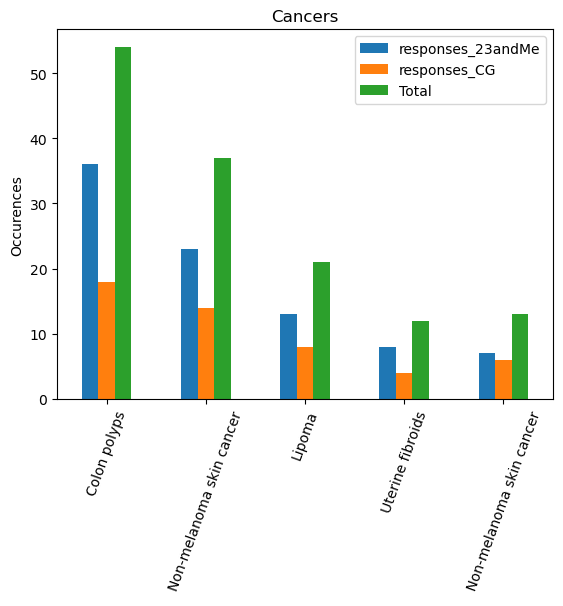

In [29]:
key = 'Cancers'
print(top_afflictions[key])
top_afflictions[key].plot.bar(ylabel = 'Occurences', title = key, rot = 70)

                                            responses_23andMe  responses_CG  \
High cholesterol (hypercholesterolemia)                    64            45   
 High triglycerides (hypertriglyceridemia)                 49            23   
 High cholesterol (hypercholesterolemia)                   47            16   
Hypothyroidism                                             36            16   
Lactose intolerance                                        32            18   

                                            Total  
High cholesterol (hypercholesterolemia)       109  
 High triglycerides (hypertriglyceridemia)     72  
 High cholesterol (hypercholesterolemia)       63  
Hypothyroidism                                 52  
Lactose intolerance                            50  


<AxesSubplot:title={'center':'ENDOCRINE'}, ylabel='Occurences'>

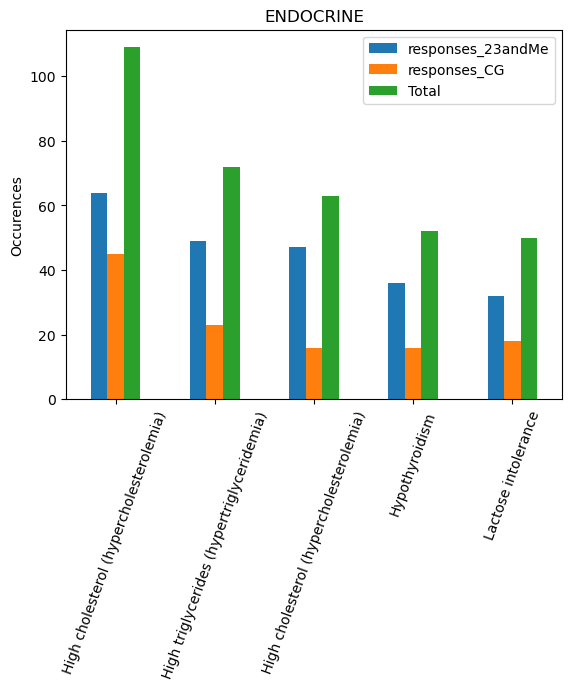

In [30]:
key = 'ENDOCRINE'
print(top_afflictions[key])
top_afflictions[key].plot.bar(ylabel = 'Occurences', title = key, rot = 70)

In [48]:
endocrine = get_survey_type(directory = '/Users/jerenolsen/Desktop/Exploring PGP Harvard/23andMe/all-data-by-profile', 
                              provider_id = '23andMe', survey_substring = 'endocrine')
endocrine1 = endocrine[endocrine[0].str.contains('diab') == True]
endocrine1.head()

,0
880,Prediabetes type 2
1102,Pre-diabetic.
1300,Pre-diabetes


In [32]:
#Debugging
top_afflictions['BLOOD'].head(20)

,responses_23andMe,responses_CG,Total
Iron deficiency anemia,106,36,142
Folate deficiency anemia,4,1,5
Other thrombophilia (includes antiphospholipid syndrome),3,1,4
low HDL blood lipids,1,1,2
elevated CA125,1,1,2


                                                    responses_23andMe  \
Iron deficiency anemia                                            106   
 Folate deficiency anemia                                           4   
 Other thrombophilia (includes antiphospholipid...                  3   
low HDL blood lipids                                                1   
 elevated CA125                                                     1   

                                                    responses_CG  Total  
Iron deficiency anemia                                        36    142  
 Folate deficiency anemia                                      1      5  
 Other thrombophilia (includes antiphospholipid...             1      4  
low HDL blood lipids                                           1      2  
 elevated CA125                                                1      2  


<AxesSubplot:title={'center':'BLOOD'}, ylabel='Occurences'>

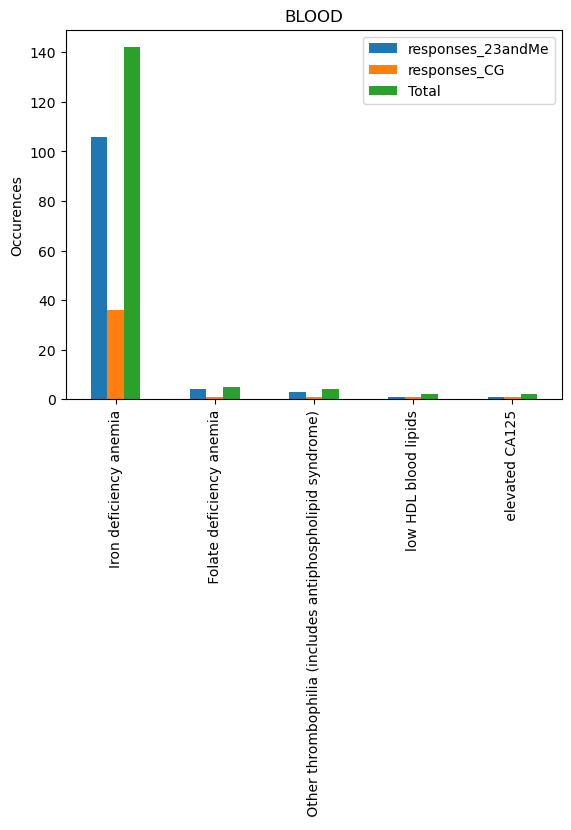

In [33]:
key = 'BLOOD'
print(top_afflictions[key])
values = top_afflictions[key]
values.plot.bar(ylabel = 'Occurences', title = key, rot = 90)

                            responses_23andMe  responses_CG  Total
Congenital heart defect                    13             4     17
Ehlers-Danlos syndrome                      9             1     10
 Ehlers-Danlos syndrome                     5             1      6
Tongue tie (ankyloglossia)                  5             2      7
Cleft uvula                                 2             1      3


<AxesSubplot:title={'center':'CONGENITAL TRAITS'}, ylabel='Occurences'>

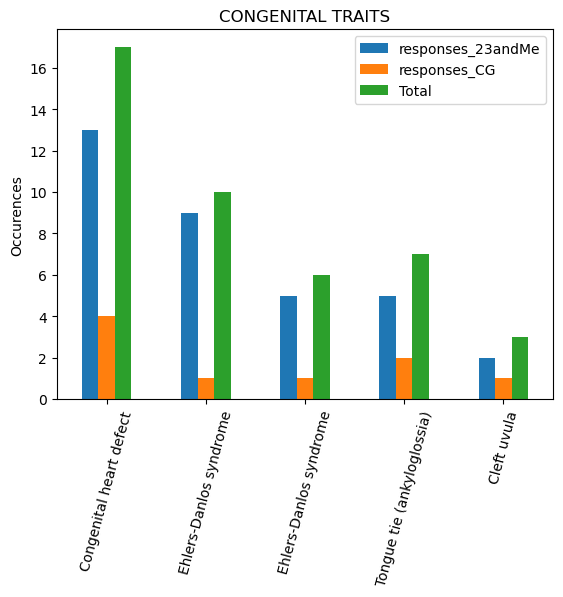

In [34]:
key = 'CONGENITAL TRAITS'
print(top_afflictions[key])
top_afflictions[key].plot.bar(ylabel = 'Occurences', title = key, rot = 75)

                           responses_23andMe  responses_CG  Total
Myopia (Nearsightedness)                 220           117    337
 Astigmatism                             165            96    261
 Floaters                                 94            55    149
 Tinnitus                                 63            24     87
 Myopia (Nearsightedness)                 46            29     75


<AxesSubplot:title={'center':'VISION'}, ylabel='Occurences'>

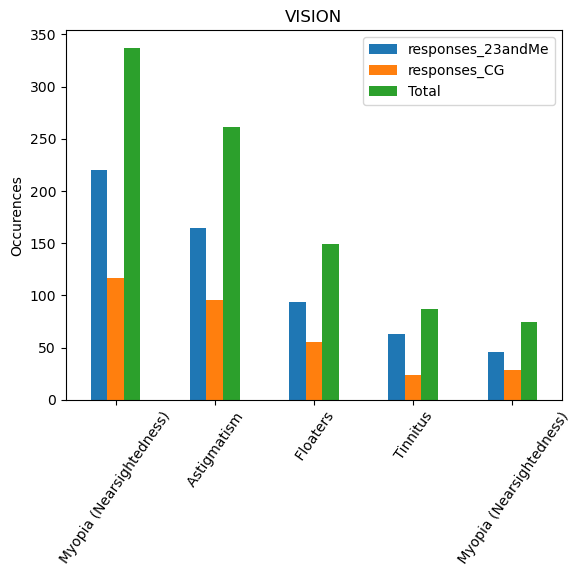

In [35]:
key = 'VISION'
print(top_afflictions[key])
top_afflictions[key].plot.bar(ylabel = 'Occurences', title = key, rot = 55)

                                                    responses_23andMe  \
 Acne                                                             167   
Dandruff                                                          130   
 Skin tags                                                         92   
 Hair loss (includes female and male pattern ba...                 64   
Eczema                                                             62   

                                                    responses_CG  Total  
 Acne                                                         81    248  
Dandruff                                                      74    204  
 Skin tags                                                    32    124  
 Hair loss (includes female and male pattern ba...            38    102  
Eczema                                                        29     91  


<AxesSubplot:title={'center':'SKIN'}, ylabel='Occurences'>

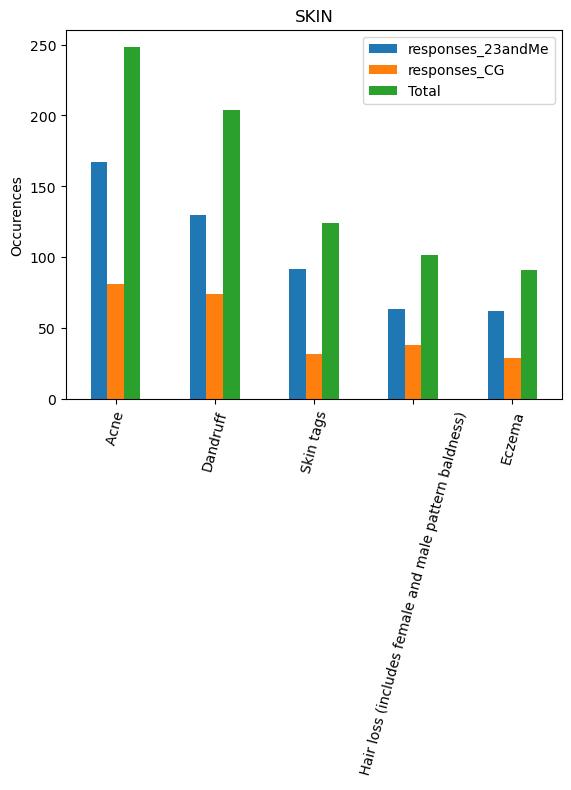

In [36]:
key = 'SKIN'
print(top_afflictions[key])
top_afflictions[key].plot.bar(ylabel = 'Occurences', title = key, rot = 75)

                             responses_23andMe  responses_CG  Total
Dental cavities                            265           168    433
 Canker sores (oral ulcers)                164            91    255
Impacted tooth                             128            75    203
 Dental cavities                           114            68    182
 Gingivitis                                105            64    169


<AxesSubplot:title={'center':'DIGESTIVE'}, ylabel='Occurences'>

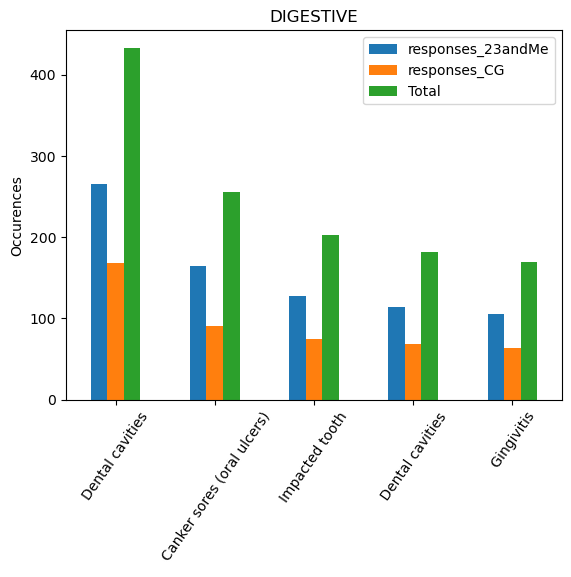

In [37]:
key = 'DIGESTIVE'
print(top_afflictions[key])
top_afflictions[key].plot.bar(ylabel = 'Occurences', title = key, rot = 55)

                         responses_23andMe  responses_CG  Total
Migraine with aura                      40            20     60
Restless legs syndrome                  33            13     46
Migraine without aura                   29            13     42
 Carpal tunnel syndrome                 23             6     29
 Migraine without aura                  22             9     31


<AxesSubplot:title={'center':'NERVOUS'}, ylabel='Occurences'>

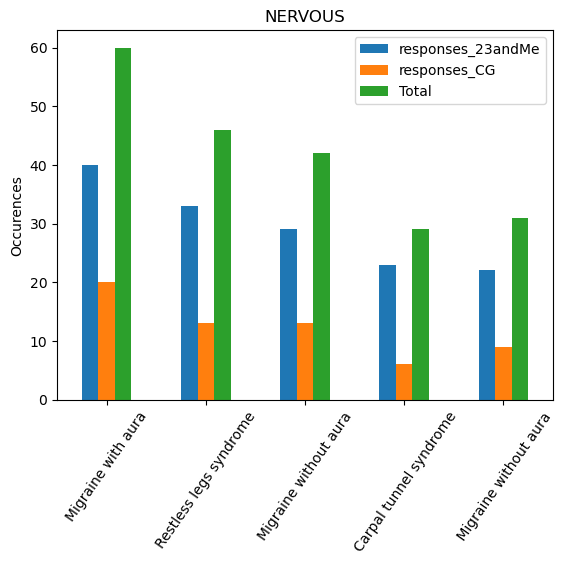

In [38]:
key = 'NERVOUS'
print(top_afflictions[key])
top_afflictions[key].plot.bar(ylabel = 'Occurences', title = key, rot = 55)

                    responses_23andMe  responses_CG  Total
Osteoarthritis                     46            28     74
 Plantar fasciitis                 39            22     61
 Flatfeet                          28            18     46
 Bone spurs                        26            10     36
 Scoliosis                         23            12     35


<AxesSubplot:title={'center':'MUSCULOSKELETAL'}, ylabel='Occurences'>

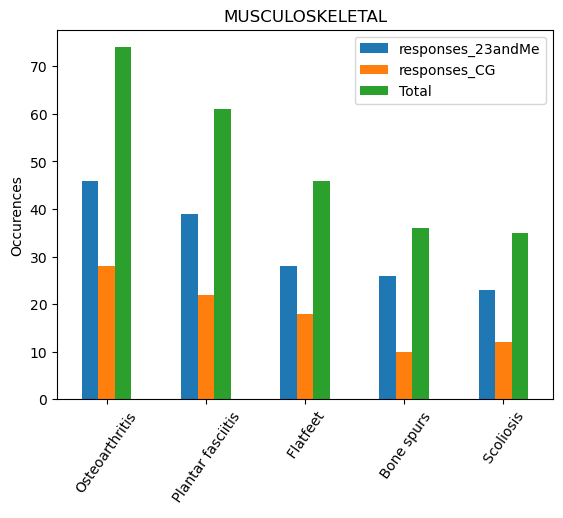

In [39]:
key = 'MUSCULOSKELETAL'
print(top_afflictions[key])
top_afflictions[key].plot.bar(ylabel = 'Occurences', title = key, rot = 55)

                      responses_23andMe  responses_CG  Total
Hypertension                         78            37    115
 Hemorrhoids                         50            31     81
Hemorrhoids                          47            24     71
 Varicose veins                      19             8     27
Raynaud's phenomenon                 13             9     22


<AxesSubplot:title={'center':'CIRCULATORY'}, ylabel='Occurences'>

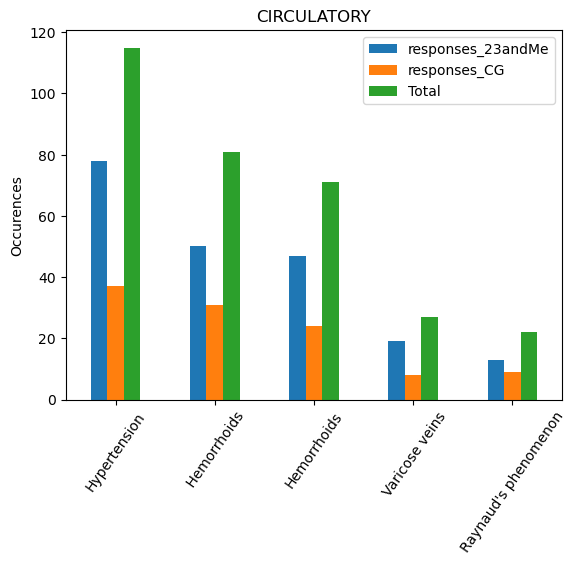

In [40]:
key = 'CIRCULATORY'
print(top_afflictions[key])
top_afflictions[key].plot.bar(ylabel = 'Occurences', title = key, rot = 55)

In [41]:
circ = top_afflictions["CIRCULATORY"]
circ.head(50)

,responses_23andMe,responses_CG,Total
Hypertension,78,37,115
Hemorrhoids,50,31,81
Hemorrhoids,47,24,71
Varicose veins,19,8,27
Raynaud's phenomenon,13,9,22


                                responses_23andMe  responses_CG  Total
Urinary tract infection (UTI)                 123            61    184
Kidney stones                                  54            28     82
 Ovarian cysts                                 41            13     54
 Urinary tract infection (UTI)                 26            11     37
 Fibrocystic breast disease                    21             3     24


<AxesSubplot:title={'center':'GENITOURINARY'}, ylabel='Occurences'>

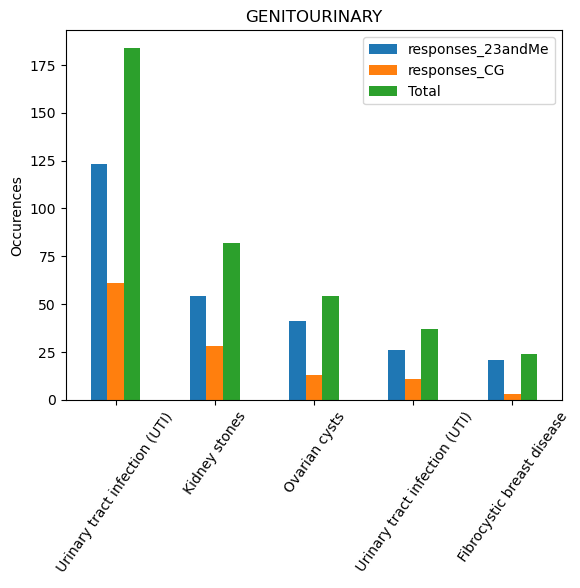

In [42]:
key = 'GENITOURINARY'
print(top_afflictions[key])
top_afflictions[key].plot.bar(ylabel = 'Occurences', title = key, rot = 55)

                    responses_23andMe  responses_CG  Total
 Allergic rhinitis                 72            28    100
 Asthma                            67            30     97
Deviated septum                    61            39    100
Allergic rhinitis                  57            32     89
Chronic sinusitis                  41            22     63


<AxesSubplot:title={'center':'RESPIRATORY'}, ylabel='Occurences'>

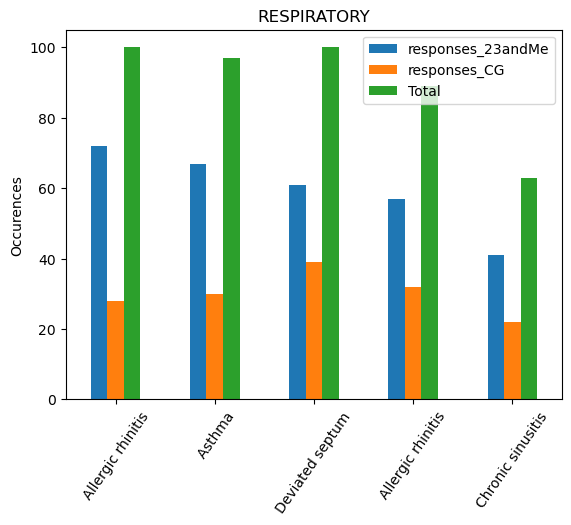

In [43]:
key = 'RESPIRATORY'
print(top_afflictions[key])
top_afflictions[key].plot.bar(ylabel = 'Occurences', title = key, rot = 55)